In [ ]:
%pip install matplotlib cmasher tqdm einops

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import cmasher as cmr
from tqdm import tqdm
import os
from einops import einsum, rearrange
import random
import matplotlib as mpl
from torch.func import jacrev, vmap

os.makedirs("img", exist_ok=True)

EPSILON = 1e-6


In [3]:
cmap = cmr.get_sub_cmap('plasma', 0.4, 1)

mpl.rcParams["axes.titlesize"] = 12.
mpl.rcParams["axes.labelsize"] = 11.
mpl.rcParams["font.size"] = 12.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = ['cm']
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.serif'] = ['CMU']

In [4]:
def get_policy_grid(n_points: int = 100):
    grid = th.stack(th.meshgrid(th.linspace(0., 1., n_points), th.linspace(0., 1., n_points), indexing='xy'))
    grid = grid.reshape(2, -1).T
    return th.stack([grid, 1 - grid], dim=-2)

P_TWO_STATE = th.stack([th.eye(2), 1. - th.eye(2)], dim=-1)

R = th.tensor([[1., 0.], [2., 0.]])

C = th.tensor([[[10., 0.], [100., 1.]]]) / 100;

B = 0.3


In [26]:
class FiniteCMDP:
    def __init__(self, 
                 P: th.tensor,
                 r: th.Tensor = None,
                 c: th.Tensor = None):
        
        self.n_states, self.n_actions = P.size(1), P.size(2)

        self.P = P
        
        if r is None:
            r = th.zeros((self.n_states, self.n_actions))
            r[random.choice(range(self.n_states)), random.choice(range(self.n_actions))] = 1.
        
        assert tuple(r.shape) == (self.n_states, self.n_actions)
        
        self.r = r

        self.n_constraints = 1
        if c is None:
            c = th.zeros((self.n_constraints, self.n_states, self.n_actions))
            for cons in range(self.n_constraints):
                c[cons, random.choice(range(self.n_states)), random.choice(range(self.n_actions))] = 1.
        
        assert tuple(c.shape) == (self.n_constraints, self.n_states, self.n_actions)
        
        self.c = c

        self.b = B
        self.mu = th.tensor([0.8, 0.2])
        self.gamma = 0.9

    def P_pi(self, policy):
        return einsum(policy, self.P, "... aa ss, ss s a -> ... ss aa s a")

    def SR(self, policy):
        P_pi_flat = rearrange(self.P_pi(policy), "... ss aa s a -> ... (ss aa) (s a)")
        SR_pi_flat = (1-self.gamma)*th.linalg.inv(th.eye(self.n_states*self.n_actions)-self.gamma*P_pi_flat)
        return rearrange(SR_pi_flat, "... (ss aa) (s a) -> ... ss aa s a", ss=self.n_states, aa=self.n_actions, s=self.n_states, a=self.n_actions)

    def Q_sa(self, policy, f):
        return einsum(self.SR(policy), f, "... ss aa s a, ... ss aa -> ... s a")

    def V_s(self, policy, f):
        return einsum(self.Q_sa(policy, f), policy, "... s a, ... a s -> ... s")

    def Vr(self, policy):
        return einsum(self.V_s(policy, self.r), self.mu, "... s, s -> ...")
    
    def Vc(self, policy):
        return einsum(self.V_s(policy, self.c), self.mu, "... n s, s -> ... n")
        
    def d_pi(self, policy):
        mu_pi = einsum(self.mu, policy, "s, ... a s -> ... s a")
        return einsum(self.SR(policy), mu_pi, "... ss aa s a, ... s a -> ... ss aa")

    def rho_pi(self, policy):
        pi_interior = np.clamp(policy, min=EPSILON, max=1-EPSILON)
        return einsum(self.d_pi(policy), 1/pi_interior, "... s a, ... a s -> ... s")
    
    def H_pi(self, policy):
        return einsum(self.d_pi(policy), -th.log(policy), "... s a, ... a s -> ...")
    
    def check_shapes(self):
        return {
            "P": self.P.shape,
            "r": self.r.shape,
            "c": self.c.shape,
            "b": self.b.shape,
            "mu": self.mu.shape,
            "gamma": (1,),
        }

policy_grid = get_policy_grid()

/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_80284/4049155607.py:98: UserWarning: The following kwargs were not used by contour: 'label'
  contours = ax.contour(env.Vc(policy_grid).reshape(100, 100),


RuntimeError: The size of tensor a (400) must match the size of tensor b (100) at non-singleton dimension 0

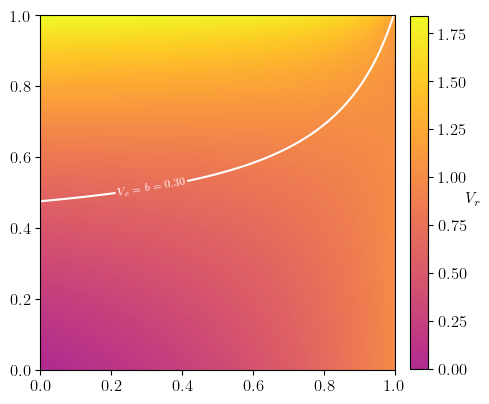

In [253]:
import torch as th
from torch.func import hessian
from copy import copy

class TabularPolicy(th.nn.Module):
    def __init__(self, env, n_policies, pi0=None, init_mode: str = "random"):
        super().__init__()
        self.env: FiniteCMDP = env
        self.n_states = self.env.n_states
        self.n_actions = self.env.n_actions
        self.n_policies = n_policies
        self.theta = self.init(init_mode) if pi0 is None else th.nn.Parameter(th.log(pi0))
    
    def init(self, init: str):
        if init == "random":
            self.theta = th.nn.Parameter(th.randn((self.n_policies, self.n_actions, self.n_states)))
        elif init == "uniform":
            self.theta = th.nn.Parameter(th.ones((self.n_policies, self.n_actions, self.n_states)))
        elif init == "right":
            theta = th.ones((self.n_policies, self.n_actions, self.n_states))
            theta[:,1,:] += 1
            self.theta = th.nn.Parameter(theta)
            
        else:
            raise ValueError("init mode unknown")
        return self.theta
    
    def softmax_policy(self, theta):
        # assuming pi(..., a|s)
        return th.softmax(theta, dim=-2)

    def forward(self):
        return self.softmax_policy(self.theta)
    
    def kakade_div(self, theta):

        with th.no_grad():
            old_pi_logits = th.log_softmax(theta, dim=-2)
            old_pi_probs = th.softmax(theta, dim=-2)
            old_d_k = self.env.d_pi(old_pi_probs)
        
        new_pi_probs = th.softmax(theta, dim=-2)
        new_pi_logits = th.log_softmax(theta, dim=-2)
        #t[(new_pi_probs == 0).expand_as(t)] = th.inf
        #t[(old_pi_probs == 0).expand_as(t)] = 0
        kl = old_d_k * (old_pi_logits - new_pi_logits)

        return kl.sum()
    
    def H_k(self, params):
        #return vmap(hessian(self.kakade_div, argnums=0))(params)
        j = vmap(jacrev(lambda x: th.log_softmax(x, dim=-2)))(params).reshape(-1, 4)
        return einsum(j, j*self.env.d_pi(th.log_softmax(params, dim=-2)).reshape(-1, 4), "... p, ... p -> ... p")
        #return th.stack([th.eye(4, 4) for _ in range(params.shape[0])]).reshape(-1, 2, 2, 2, 2)

    def kakade_nat_grad(self, params, grad):
        h = self.H_k(params)

        with th.no_grad():
            h_flat = rearrange(h, "batch a s aa ss -> batch (a s) (aa ss)")
            theta_grad_flat = rearrange(grad, "batch a s -> batch (a s)")
            g_nat_flat = th.linalg.lstsq(h_flat, theta_grad_flat).solution
            #g_nat = rearrange(g_nat_flat, "batch (a s) -> batch a s", a=self.n_actions, s=self.n_states)
            g_nat = th.linalg.lstsq(h.reshape(-1, 4, 4), grad.reshape(-1, 4)).solution.reshape(-1, 2, 2)

        return g_nat

    def train(self, env, n_steps=5000, lr=0.1, mode="VPG", entropy=0.):

        optimizer = th.optim.SGD(self.parameters(), lr=lr, momentum=0., dampening=0., weight_decay=0., nesterov=False)

        policies = []

        for _ in tqdm(range(n_steps)):
            optimizer.zero_grad()
            loss = - self.env.Vr(self.forward()) 
            
            if entropy:
                loss -= entropy*self.env.H_pi(self.forward())

            loss.sum().backward()

            if mode == "NPG":
                self.theta.grad = self.kakade_nat_grad(self.theta, self.theta.grad)

            self.theta = th.nn.Parameter(self.theta - lr*self.theta.grad)

            policies.append(self.forward())

        return policies

_, ax = plt.subplots(1, 1,  figsize=(5, 5))

env = FiniteCMDP(P=P_TWO_STATE, r=R, c=C)

# plot return and constraint
heatmap = ax.imshow(env.Vr(policy_grid).reshape(100, 100), origin='lower', extent=(0, 1, 0, 1), cmap=cmap)
contours = ax.contour(env.Vc(policy_grid).reshape(100, 100),
                          levels=np.array([B]),
                          antialiased=True,
                          colors="white",
                          linestyles="solid",
                          extent=(0, 1, 0, 1), label=r"$D_{KL}$")
ax.clabel(contours, fontsize=8, fmt=r"$V_c=b=%.2f$", use_clabeltext=True, rightside_up=True)

cbar = ax.figure.colorbar(heatmap, ax=ax, fraction=0.0455, pad=0.04)
cbar.ax.set_ylabel(r"$V_r$", rotation=0) #va="bottom")

pi = TabularPolicy(env=env, n_policies=1, pi0=get_policy_grid(n_points=10))
hessians = pi.H_k(pi.theta).reshape(-1, 4, 4)
p = pi.forward()
X, Y = p[:, 0, 0].detach(), p[:, 0, 1].detach()
_, eigs = th.linalg.eigh(hessians)

U, V = eigs[:, 0].detach().reshape(-1, 2, 2)[:, 0, 0], eigs[:, 0].detach().reshape(-1, 2, 2)[:, 0, 1]
ax.quiver(X, Y, U, V)
U, V = eigs[:, 1].detach().reshape(-1, 2, 2)[:, 0, 0], eigs[:, 1].detach().reshape(-1, 2, 2)[:, 0, 1]
ax.quiver(X, Y, U, V)

ax.set_xlabel("$\pi(a_1|s_1)$")
ax.set_ylabel("$\pi(a_1|s_2)$")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
# ax.axis("off")
# ax.legend()

def plot_pg_flow(pi, ax=None):
    print(pi.shape)
    for i in range(pi.shape[1]):
        ax.plot(pi[:, i, 0, 0].detach(), pi[:, i, 0, 1].detach(), linestyle="solid", label="VPG")

pi = TabularPolicy(env, 1, init_mode="random")
policies = pi.train(env, n_steps=50, mode="NPG", entropy=0., lr=0.01)
plot_pg_flow(th.stack(policies), ax=ax)

plt.show()


/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_80284/995682060.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  contours = ax.contour(env.Vc(policy_grid).reshape(100, 100),
  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:02<00:00, 2458.73it/s]


torch.Size([5000, 10, 2, 2])


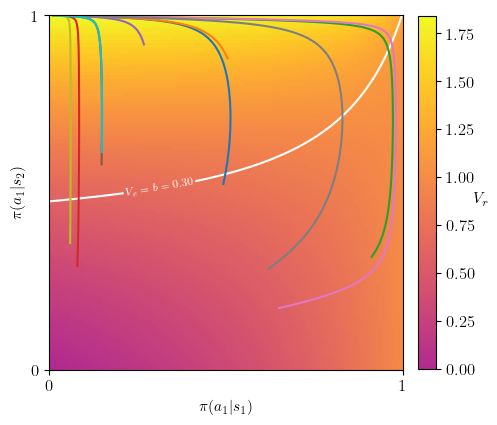

In [200]:
_, ax = plt.subplots(1, 1,  figsize=(5, 5))

env = FiniteCMDP(P=P_TWO_STATE, r=R, c=C)

# plot return and constraint
heatmap = ax.imshow(env.Vr(policy_grid).reshape(100, 100), origin='lower', extent=(0, 1, 0, 1), cmap=cmap)
contours = ax.contour(env.Vc(policy_grid).reshape(100, 100),
                          levels=np.array([B]),
                          antialiased=True,
                          colors="white",
                          linestyles="solid",
                          extent=(0, 1, 0, 1), label=r"$D_{KL}$")
ax.clabel(contours, fontsize=8, fmt=r"$V_c=b=%.2f$", use_clabeltext=True, rightside_up=True)

cbar = ax.figure.colorbar(heatmap, ax=ax, fraction=0.0455, pad=0.04)
cbar.ax.set_ylabel(r"$V_r$", rotation=0) #va="bottom")

ax.set_xlabel("$\pi(a_1|s_1)$")
ax.set_ylabel("$\pi(a_1|s_2)$")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
# ax.axis("off")
# ax.legend()

def plot_pg_flow(pi, ax=None):
    print(pi.shape)
    for i in range(pi.shape[1]):
        ax.plot(pi[:, i, 0, 0].detach(), pi[:, i, 0, 1].detach(), linestyle="solid", label="VPG")

pi = TabularPolicy(env, 10, init_mode="random")
policies = pi.train(env, n_steps=5000, mode="VPG", entropy=0., lr=0.1)
plot_pg_flow(th.stack(policies), ax=ax)

plt.show()

/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_80284/2758775359.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  contours = ax.contour(env.Vc(policy_grid).reshape(100, 100),
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 205.61it/s]


torch.Size([50, 10, 2, 2])


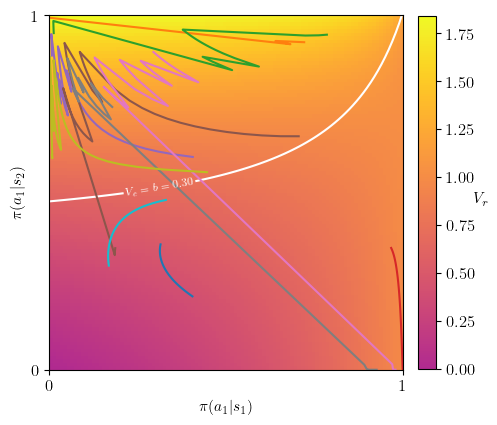

In [201]:
_, ax = plt.subplots(1, 1,  figsize=(5, 5))

env = FiniteCMDP(P=P_TWO_STATE, r=R, c=C)

# plot return and constraint
heatmap = ax.imshow(env.Vr(policy_grid).reshape(100, 100), origin='lower', extent=(0, 1, 0, 1), cmap=cmap)
contours = ax.contour(env.Vc(policy_grid).reshape(100, 100),
                          levels=np.array([B]),
                          antialiased=True,
                          colors="white",
                          linestyles="solid",
                          extent=(0, 1, 0, 1), label=r"$D_{KL}$")
ax.clabel(contours, fontsize=8, fmt=r"$V_c=b=%.2f$", use_clabeltext=True, rightside_up=True)

cbar = ax.figure.colorbar(heatmap, ax=ax, fraction=0.0455, pad=0.04)
cbar.ax.set_ylabel(r"$V_r$", rotation=0) #va="bottom")

ax.set_xlabel("$\pi(a_1|s_1)$")
ax.set_ylabel("$\pi(a_1|s_2)$")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
# ax.axis("off")
# ax.legend()

def plot_pg_flow(pi, ax=None):
    print(pi.shape)
    for i in range(pi.shape[1]):
        ax.plot(pi[:, i, 0, 0].detach(), pi[:, i, 0, 1].detach(), linestyle="solid", label="VPG")

pi = TabularPolicy(env, 10, init_mode="random")
policies = pi.train(env, n_steps=50, mode="NPG", entropy=0., lr=0.01)
plot_pg_flow(th.stack(policies), ax=ax)

plt.show()

In [177]:
policies[0][0, :, :], policies[-1][0, :, :]

(tensor([[1., 0.],
         [0., 1.]], grad_fn=<SliceBackward0>),
 tensor([[1., 0.],
         [0., 1.]], grad_fn=<SliceBackward0>))